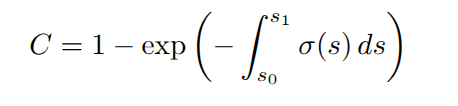

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.random.manual_seed(0)

In [2]:
def get_c(sigma, s):
  w = torch.trapezoid(sigma, s, dim=-1)
  C = 1 - torch.exp(-w)
  
  return C

In [3]:
# --------------- a. Synthetic demo data (replace with your loader) ------------
R, N = 8, 128                         
case = 2

In [4]:
def get_case(case):
  if case == 1:
    s = torch.rand(R, N)                  # sample positions (shuffled, just for demo)
    s, _ = torch.sort(s, dim=-1)          # sort so they go from s0→s1
    sigma_true = torch.sin(4*s) + 2       # some "ground-truth" σ(s)
  elif case == 2:
    s = torch.rand(R, N) * 0.5 * torch.pi                  
    s, _ = torch.sort(s, dim=-1)          #
    sigma_true = torch.clip(20 * torch.sin(4*s), 0, 1000)
  return sigma_true, s 

sigma_true, s = get_case(case)

C = get_c(sigma_true, s)   # ground-truth integral

# Send everything to the same device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
s, C = s.to(device), C.to(device)

In [5]:
print(torch.min(s))
print(torch.max(s))

tensor(0.0001, device='cuda:0')
tensor(1.5705, device='cuda:0')


In [6]:
class SigmaNet(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            nn.Linear(1, 64), nn.ReLU(), nn.Linear(64, 1), nn.Softplus()
        )

    def forward(self, x):
        return self.layers(x.unsqueeze(-1)).squeeze(-1)
      
model = SigmaNet()
model = model.to(device)
model.layers

Sequential(
  (0): Linear(in_features=1, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=1, bias=True)
  (3): Softplus(beta=1.0, threshold=20.0)
)

In [7]:
def forward_pass(model, s):
  sig_hat = model(s)
  C_hat = get_c(sig_hat, s)
  return C_hat

In [8]:
print(f"Initial:")
C_hat = forward_pass(model, s)
print(f"True C: {C}")
print(f"pred C: {C_hat}")
print(f"Loss: {F.mse_loss(C_hat, C)}")

Initial:
True C: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
pred C: tensor([0.6207, 0.6138, 0.6203, 0.6185, 0.6170, 0.6118, 0.6219, 0.6215],
       device='cuda:0', grad_fn=<RsubBackward1>)
Loss: 0.1457597017288208


In [9]:
lr = 0.1
epochs = 1000
optimizer = torch.optim.SGD(model.parameters(), lr)
loss_hist = []
for epoch in range(epochs):
  optimizer.zero_grad()
  C_hat = forward_pass(model, s)
  loss = F.mse_loss(C_hat, C)
  loss_hist.append(loss.item())
  loss.backward()
  optimizer.step()
  if epoch % 10 == 0:
    print(f"epoch: {epoch:02d} | loss: {loss:+.2f}")
    # print(f"epoch: {epoch:02d} | loss: {loss:+.2f} | C:{C} | C_hat:{C_hat}")
  

epoch: 00 | loss: +0.15
epoch: 10 | loss: +0.01
epoch: 20 | loss: +0.01
epoch: 30 | loss: +0.00
epoch: 40 | loss: +0.00
epoch: 50 | loss: +0.00
epoch: 60 | loss: +0.00
epoch: 70 | loss: +0.00
epoch: 80 | loss: +0.00
epoch: 90 | loss: +0.00
epoch: 100 | loss: +0.00
epoch: 110 | loss: +0.00
epoch: 120 | loss: +0.00
epoch: 130 | loss: +0.00
epoch: 140 | loss: +0.00
epoch: 150 | loss: +0.00
epoch: 160 | loss: +0.00
epoch: 170 | loss: +0.00
epoch: 180 | loss: +0.00
epoch: 190 | loss: +0.00
epoch: 200 | loss: +0.00
epoch: 210 | loss: +0.00
epoch: 220 | loss: +0.00
epoch: 230 | loss: +0.00
epoch: 240 | loss: +0.00
epoch: 250 | loss: +0.00
epoch: 260 | loss: +0.00
epoch: 270 | loss: +0.00
epoch: 280 | loss: +0.00
epoch: 290 | loss: +0.00
epoch: 300 | loss: +0.00
epoch: 310 | loss: +0.00
epoch: 320 | loss: +0.00
epoch: 330 | loss: +0.00
epoch: 340 | loss: +0.00
epoch: 350 | loss: +0.00
epoch: 360 | loss: +0.00
epoch: 370 | loss: +0.00
epoch: 380 | loss: +0.00
epoch: 390 | loss: +0.00
epoch: 400

In [10]:
print(f"Final:")
C_hat = forward_pass(model, s)
print(f"True C: {C}")
print(f"pred C: {C_hat}")
print(f"Loss: {F.mse_loss(C_hat, C)}")

Final:
True C: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
pred C: tensor([0.9919, 0.9914, 0.9920, 0.9919, 0.9917, 0.9910, 0.9920, 0.9920],
       device='cuda:0', grad_fn=<RsubBackward1>)
Loss: 6.770902837160975e-05


Text(0.5, 1.0, 'Training ')

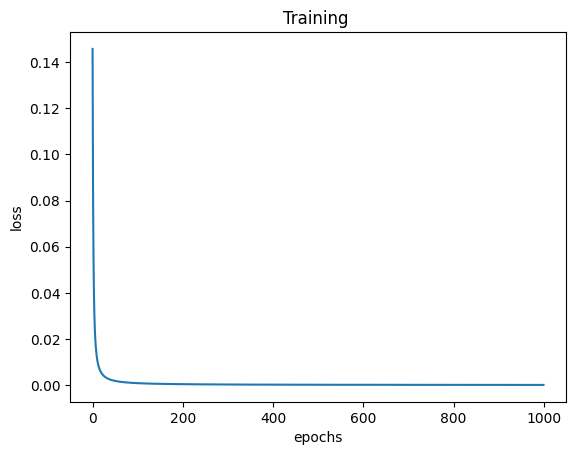

In [11]:
plt.plot(range(epochs), loss_hist)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title("Training ")

In [12]:
sig_hat = model(s)
C_hat = forward_pass(model, s)
print(f"Sigma True: {sigma_true}")
print(f"Sigma predicted: {sig_hat}")
print(f"C True: {C}")
print(f"C_hat: {C_hat}")
loss = F.mse_loss(C_hat, C)
print(f"Loss: {loss}")

Sigma True: tensor([[0.1553, 0.6448, 2.5535,  ..., 0.0000, 0.0000, 0.0000],
        [2.0640, 2.2302, 4.0033,  ..., 0.0000, 0.0000, 0.0000],
        [0.5561, 0.8456, 2.1265,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [2.0491, 4.1143, 5.1247,  ..., 0.0000, 0.0000, 0.0000],
        [0.0100, 1.6221, 2.5260,  ..., 0.0000, 0.0000, 0.0000],
        [0.0804, 0.3184, 0.3523,  ..., 0.0000, 0.0000, 0.0000]])
Sigma predicted: tensor([[1.8818, 1.8895, 1.9213,  ..., 4.3066, 4.3326, 4.3779],
        [1.9131, 1.9158, 1.9457,  ..., 4.3153, 4.3182, 4.3713],
        [1.8881, 1.8928, 1.9141,  ..., 4.3032, 4.3825, 4.3852],
        ...,
        [1.9128, 1.9476, 1.9650,  ..., 4.3151, 4.3274, 4.3545],
        [1.8795, 1.9057, 1.9208,  ..., 4.3782, 4.3804, 4.3835],
        [1.8806, 1.8844, 1.8849,  ..., 4.3626, 4.3707, 4.3827]],
       device='cuda:0', grad_fn=<SqueezeBackward1>)
C True: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
       device='cuda:0')
C_hat: tensor([0.9

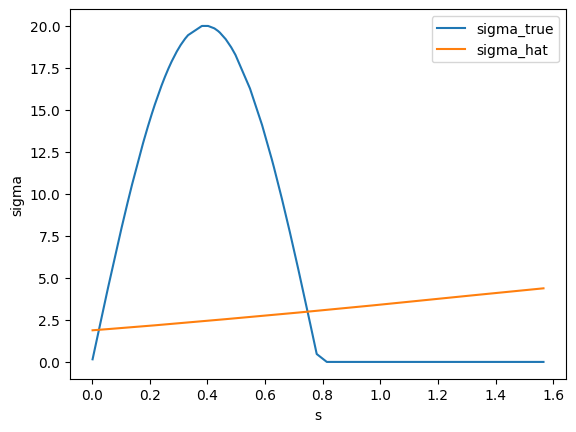

In [13]:
idx = 0
plt.plot(s[idx].detach().cpu().numpy(), sigma_true[idx].detach().cpu().numpy(), label='sigma_true');
plt.plot(s[idx].detach().cpu().numpy(), sig_hat[idx].detach().cpu().numpy(), label='sigma_hat');
plt.xlabel('s')
plt.ylabel('sigma')
plt.legend()

## The conclstion: Also, I learned C but the hidden sigma not match